### Typical values, oddballs
### Variance and Fano factor (standardize data) 
### Some common distributions
### A bit more w/ the normal (CDF) 
### 

# Case Study: Neuronal morphology

We'll organize today's tour and analysis around the study of cellular morphology. Basically, this is a fancy way of saying we'll be thinking about cells' shapes, their geometry, and their branching patterns. The study of cellular morphology has a very illustrious history in neuroscience, and was integral to the development of the neuron doctrine: the idea that brain cells are individual units with freely ending fibers. It can seem hard to imagine ever having found this surprising, but this was fiercely contested by some of the finest minds in science in the nineteenth and even early twentieth centuries. The Spaniard Santiago Ramon y Cajal is usually considered the chief mason of the neuron doctrine. Working with what we'd now consider a very rudimentary microscope, and well before the advent of modern biological imaging, Cajal channeled his artistic energies and cataloged the myriad cellular forms he saw under the microscope in a series of thousands of drawings. These are among the great monuments of scientific artwork and scientific discovery, and still find their way to art galleries around the world. 

Let's fastforward into the twentyfirst century, where we can easily access morphological data obtained from filling neurons with dyes and labels of different kinds. The block of code below imports some libraries we'll need, and also puts some some morphology data in our hands, courtesy of the Allen Institute. 

In [164]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cell_specimen_id = 576107598
morphology = ctc.get_reconstruction(cell_specimen_id)
markers = ctc.get_reconstruction_markers(cell_specimen_id) 


features = pd.DataFrame(ctc.get_all_features(require_reconstruction=True))
cell_metadata = pd.DataFrame(ctc.get_cells())

features_morpho = features.loc[:,'average_bifurcation_angle_local':]

df = pd.merge(features[['vrest', 'number_branches', 'threshold_v_ramp', 'total_volume']], 
              cell_metadata[['species', 'name', 'structure_hemisphere']], 
              left_index=True, right_index=True)

The object above called 'morphology' is a data file for a single cell. It contains information we can use to render the cell's shape, but it's not really in a format that's going to immediately make sense, visually. It's more like a long list of geometric properties (lengths and radii of short cylinders, and instructions for how to connect them). There's also metadata on the quality of reconstruction, etc. The block of code below does a little bit of work so we can see the cell. It's a lightly edited version of code you can find on one of the Allen's [sample notebooks] (https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html)

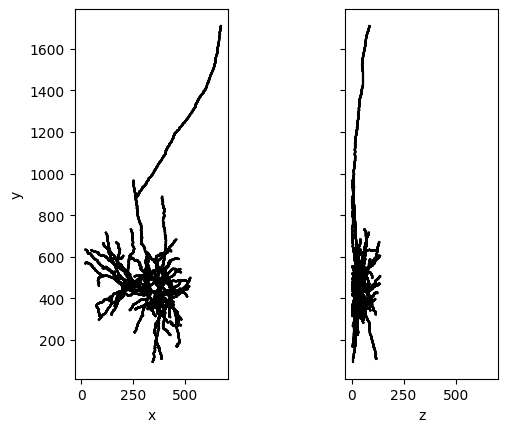

In [113]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
lens = [] # array of segment lengths

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')
        this_len = ((n['x'] - c['x']) ** 2) + ((n['y'] - c['y']) ** 2) + ((n['z'] - c['z']) ** 2)
        lens.append(this_len ** 0.5) # Euclidian distance btw. nodes
        
axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
plt.show()

Quite pretty! At the risk of stating the obvious, you can see that there's a bit of variability in the branch lengths. Some are tiny, some are long, and one is super-long. Thinking about the branch lengths is actually a nice metaphor for the idea of a **distribution**. Recall from last time that the distribution of a variable (such as branch length) is a sort of bird's eye description of how frequently we expect to find it in different ranges. If we wanted to give a handwavy, highly non-quantititive description of the distribution of branch lengths for this one neuron, just from eyeballing it, it might be something like: Beans.

Let's see if the numbers agree with our intuition.  

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

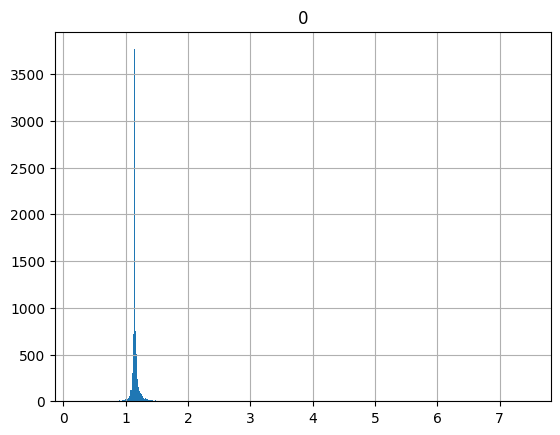

In [120]:
pd.DataFrame(lens).hist(bins=800)

In [153]:
morphology.compartment_list_by_type('terminal')

[]

In [122]:
dir(morphology)

['APICAL_DENDRITE', 'AXON', 'BASAL_DENDRITE', 'DENDRITE', 'NODE_TYPES', 'SOMA', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_consistency', '_compartment_index', '_compartment_list', '_find_type_boundary', '_print_all_nodes', '_reconstruct', '_reset_tree_ids', '_resolve_node_type', '_separate_trees', '_set_compartments', '_soma', '_tree_list', 'append', 'apply_affine', 'change_parent', 'children_of', 'compartment_index', 'compartment_index_by_type', 'compartment_list', 'compartment_list_by_type', 'convert_type', 'delete_tree', 'find', 'node', 'num_nodes', 'num_trees', 'parent_of', 'root', 'save', 'soma', 'sparsify', 'strip_all_other_types', 'strip_type', 'stumpify_axon', 'tree', 'write

In [4]:
morpho_features = features.loc[:,'average_bifurcation_angle_local':]

In [6]:
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
morpho_features = morpho_features.select_dtypes(include=num_types)

<AxesSubplot:>

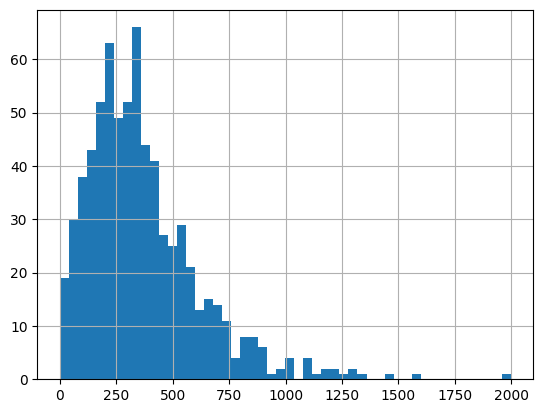

In [17]:
morpho_features['soma_surface'].hist(bins=50)

<AxesSubplot:>

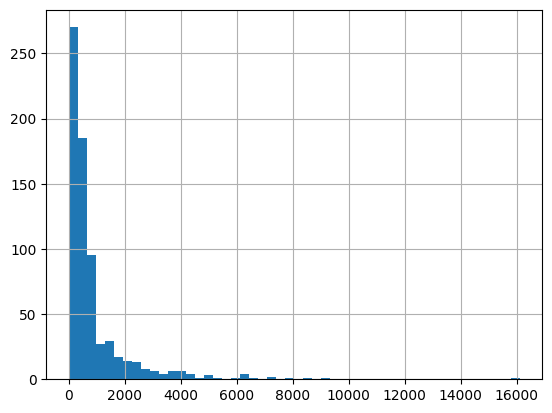

In [16]:
morpho_features['total_volume'].hist(bins=50)

In [18]:
import numpy as np
import statsmodels.api as sm
import pylab as py

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


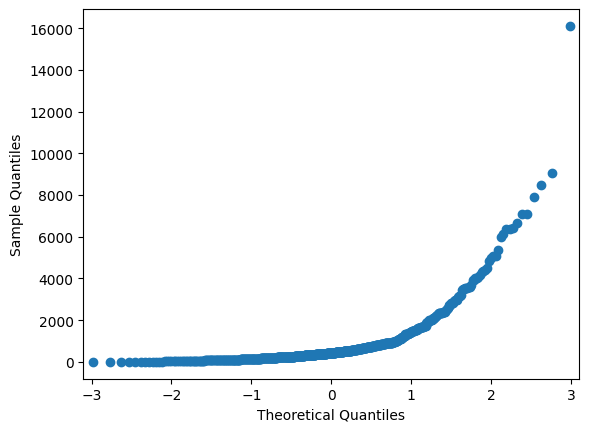

In [25]:
sm.qqplot(morpho_features['total_volume'])
py.show()

# UPPING YOUR PANDAS GAME

Let's take a detour and dive a bit more into Pandas. It's worth gaining some familiarity with, and whether data analysis feels fun vs. frustrating (not that it can't be both!) will in large part boil down to how comfortable you are using this library. Pandas isn't hard the way quantum physics is hard; rather, it's hard the way that cooking is hard. There are a set of basic skills and 'idioms' that get used again and again, which, if you lack them, make the endeavor miserable and disaster-prone. But if you have these skills (and they are definitely super-learnable with patience and practice), they can open up an entire world for you. 

## Pandas Idiom 1: Getting subsets of your dataframe

We saw last time how to grab one or several columns of interest from a dataframe, by specifying them individually with a syntax like: 

In [157]:
features[['adaptation', 'total_volume']].head(5)

,adaptation,total_volume
0,NaN,2355.765059
1,NaN,2962.024123
2,0.044825,460.354199
3,0.002303,129.985840
4,0.093492,204.115177


Above, we've said: "throw away everything that isn't 'adaptation' or 'total_volume'". Sometimes, though, it's much easier to specify a range of columns without enumerating every single one. Say we were interested in grabbing all of the morphology features from the features dataframe. There are about 30 of them (and they're the last columns of the dataframe), and it would be a real pain to type each feature out and put it in brackets. Instead, we can use this trick: 

In [160]:
features.loc[:,'average_bifurcation_angle_local':].head(5)

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
0,72.604110,NaN,0.850561,0.527213,75.133929,0.966709,NaN,668702901,11.0,496.779715,...,581.674568,0.1144,0.1144,0.28,444.247484,False,3D Neuron Reconstruction morphology,9995.218601,16666.213729,2355.765059
1,68.499396,NaN,0.934072,0.614133,61.172414,0.892380,NaN,680036168,13.0,474.631942,...,391.393464,0.1144,0.1144,0.28,1997.534304,False,3D Neuron Reconstruction morphology,6533.385774,13173.179026,2962.024123
2,77.679949,NaN,0.895664,0.488865,48.027778,0.928510,NaN,496001072,5.0,334.170810,...,236.976305,0.1144,0.1144,0.28,522.952356,False,3D Neuron Reconstruction morphology,2067.805445,3180.344934,460.354199
3,73.926537,NaN,0.896227,0.216384,62.282609,0.993927,NaN,596792650,4.0,226.722766,...,332.948545,0.1144,0.1144,0.28,76.604264,False,3D Neuron Reconstruction morphology,3488.103438,2371.871389,129.985840
4,89.985385,NaN,0.821116,0.289549,54.000000,1.000000,NaN,599474134,7.0,228.889283,...,374.603996,0.1144,0.1144,0.28,77.936062,False,3D Neuron Reconstruction morphology,2977.161146,2703.134880,204.115177


The .loc operator lets us do numpy style slicing, were we can specify sets of continuous rows and columns that we want to slice over. The basic syntax is: 

dataframe.loc[row expression, column expression]

The :, above, in the row expression says, as in numpy "get me all the rows". The 'average_bifurcation_angle_local': expression in the column expression says "get me columns starting from 'average_bifurcation angle', and extending to the end of the dataframe. 

If, instead, you wanted to grab all the rows, and columns ranging from 'average_bifurcation angle' to 'average_diameter', the relevant expression would be: 

In [161]:
features.loc[:,'average_bifurcation_angle_local':'average_diameter'].head(5)

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter
0,72.604110,NaN,0.850561,0.527213
1,68.499396,NaN,0.934072,0.614133
2,77.679949,NaN,0.895664,0.488865
3,73.926537,NaN,0.896227,0.216384
4,89.985385,NaN,0.821116,0.289549


Recall that .head(5) in the above examples is just telling pandas to show the first 5 rows. It dosn't have anything to do with the actual query we're performing.

## Pandas Idiom 2: Filtering your data on the basis of a conditional

In the .loc example above, we knew in advance what exact subset of our data we were looking for, and how to call it explicitly. A lot of the time, though, we don't know the exact rows or columns we'd like to grab, just that we're interested in a set of rows/columns that have something in common, or meet some criterion. For example, we might want rows that correspond only to mouse data, and not human data. Or we might want rows where the average diamater is greater than some certain value.

That latter query (selecting for diameters above a certain threshold) would look like this: 

In [172]:
features_morpho[features_morpho['average_diameter'] > 0.9]

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume
47,81.578194,NaN,0.802499,1.033745,67.100000,1.000000,NaN,680043920,12.0,475.663692,...,518.922373,0.1144,0.1144,0.28,918.551337,False,3D Neuron Reconstruction morphology,4006.243938,12930.564179,4322.984221
323,82.830914,NaN,0.792147,1.156730,68.000000,0.993137,NaN,673700971,8.0,356.752592,...,370.970282,0.1144,0.1144,0.28,253.123638,False,3D Neuron Reconstruction morphology,5784.522053,21069.567363,6677.460448
609,81.654732,NaN,0.715295,1.003061,145.794118,1.000000,NaN,603515592,6.0,516.702575,...,884.731477,0.1144,0.1144,0.28,527.632192,False,3D Neuron Reconstruction morphology,6075.055529,19151.512838,4986.316997


Let's unpack this, because it has a nested structure that can look a bit confusing at first. If we were to run the expression inside the outer bracket, we'd get the following: 

In [173]:
features_morpho['average_diameter'] > 0.9

0      False
1      False
2      False
3      False
4      False
       ...  
696    False
697    False
698    False
699    False
700    False
Name: average_diameter, Length: 701, dtype: bool

The expression is basically asking "is it the case that the average diameter is greater than 0.9?". It evaluates as false just about everywhere, and is true only for 3 rows where the condition is met. When we then feed this long list of 'True's and 'False's to the dataframe, it knows that you're asking for the data only where the condition evalues as 'True'. 

# Typical values and oddball values in your dataset

Pandas makes it easy to get summary statistics for our data table:

In [177]:
features_morpho.describe()

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id_y,max_branch_order,max_euclidean_distance,...,overall_depth,overall_height,overall_width,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,total_length,total_surface,total_volume
count,701.000000,0.0,701.000000,701.000000,701.000000,701.000000,0.0,7.010000e+02,701.000000,701.000000,...,701.000000,701.000000,701.000000,7.010000e+02,7.010000e+02,7.010000e+02,7.010000e+02,701.000000,701.000000,701.000000
mean,74.460981,NaN,0.878751,0.429317,57.034323,0.925859,NaN,5.859577e+08,7.723252,399.774930,...,93.769329,516.545095,325.709312,1.144000e-01,1.144000e-01,2.800000e-01,3.677248e+02,3832.188239,5699.400884,860.789884
std,8.246954,NaN,0.037041,0.160866,24.358354,0.076322,NaN,8.154347e+07,4.207190,227.038369,...,35.948250,281.136395,132.166569,1.972053e-15,1.972053e-15,9.999142e-16,2.534457e+02,2788.219926,5992.137552,1327.563202
min,49.483210,NaN,0.656121,0.000007,15.897436,0.622167,NaN,3.979053e+08,1.000000,63.020752,...,21.840000,54.607838,49.173247,1.144000e-01,1.144000e-01,2.800000e-01,7.668893e-08,251.987893,0.021819,-0.000076
25%,68.869230,NaN,0.861384,0.323491,41.479167,0.866617,NaN,4.961640e+08,5.000000,231.429096,...,66.777700,318.348333,231.013889,1.144000e-01,1.144000e-01,2.800000e-01,1.947356e+02,2224.234529,2373.483208,214.074139
50%,74.524769,NaN,0.884663,0.427836,50.818182,0.946812,NaN,5.874055e+08,6.000000,357.341058,...,89.302100,470.916212,292.386327,1.144000e-01,1.144000e-01,2.800000e-01,3.207796e+02,2949.286234,3748.792341,429.377765
75%,80.048330,NaN,0.904748,0.525646,67.100000,0.994360,NaN,6.528365e+08,10.000000,488.584760,...,119.145600,646.759680,398.576603,1.144000e-01,1.144000e-01,2.800000e-01,4.800480e+02,4248.902167,6182.628143,878.339557
max,115.432036,NaN,0.948915,1.156730,253.700000,1.122363,NaN,8.460831e+08,28.000000,1623.575309,...,183.960000,1988.717896,1295.286608,1.144000e-01,1.144000e-01,2.800000e-01,1.997534e+03,21775.359101,59086.631128,16108.163739


In [ ]:
Let's 

<AxesSubplot:>

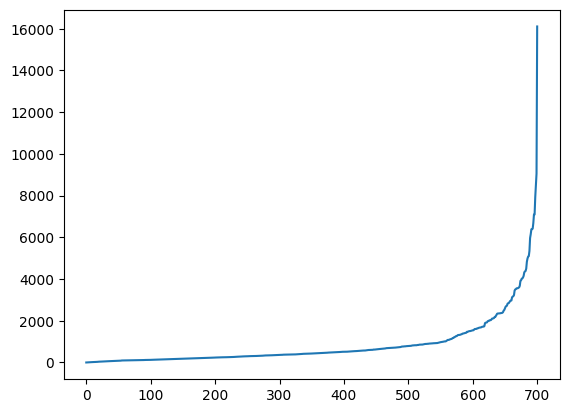

In [33]:
morpho_features['total_volume'].sort_values().plot(use_index=False)

#.loc and .iloc

In [51]:
n = morpho_features['total_volume'].shape[0]
pctile = 90

idx = np.floor(n * pctile / 100).astype(int)
morpho_features['total_volume'].sort_values().iloc[idx]

2104.69584412496

### Questions we might have about our data: 

- I see a cell with 125 branches. Is that unusual? How much of an oddball is it? 
- Calculate the median 
- 10th percentile -- what is it?  [PERCENTILES] 
- Only 10% of my data have a value that extreme [CDF]

STEPS: 
1) Sort them in ascending order
2) Blah

### Leveling up our pandas game

1. Conditionals/queries.

2. Dropping stuff we don't want. 

3. Taking care of missing values. 

4. The index

# Distributions: The underlying story of your data.

The variability of our features is trying to tell a story, and typically we want to try to address exactly how variable a given features is, whether that variability has some specific kind of underlying structure, and whether the variability we observe is shared with other variables. We'll take these issues in turn. 



- HOW Variable is it? 
- Does the variability have some structure, and if so, what kind of underlying physical/biological process explains that structure? 
- Is the variability shared with [...]


In [180]:
morpho_features.columns

Index(['average_bifurcation_angle_local', 'average_bifurcation_angle_remote',
       'average_contraction', 'average_diameter', 'average_fragmentation',
       'average_parent_daughter_ratio', 'hausdorff_dimension', 'id_y',
       'max_branch_order', 'max_euclidean_distance', 'max_path_distance',
       'number_bifurcations', 'number_branches', 'number_nodes',
       'number_stems', 'number_tips', 'overall_depth', 'overall_height',
       'overall_width', 'scale_factor_x', 'scale_factor_y', 'scale_factor_z',
       'soma_surface', 'total_length', 'total_surface', 'total_volume'],
      dtype='object')

Average Bifurcation Angle: Normal

Exponential: Typically describes interval data. 

- average_bifurcation_angle_local: gaussian
- number bifurcations (11): exponential
- number_nodes (13)
- number tips (15): Exponential
- overall depth (16): Uniform


Uniform: There's nothing 'typical' about it. No real characteristic value. "Gonna tend to bunch up around"

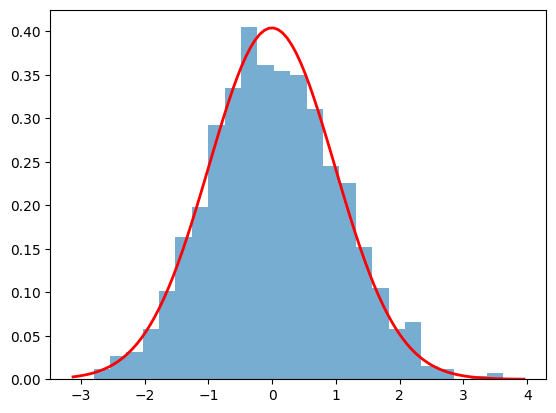

In [256]:

# Sample from each type of distribution and have a look.

from scipy.stats import norm
data_norm = norm.rvs(0,1, size=1000)

#plt.plot(data_norm,'o');
plt.hist(data_norm, bins=25, density=True, alpha=0.6);
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
mu, std = norm.fit(data_norm)
plt.show()



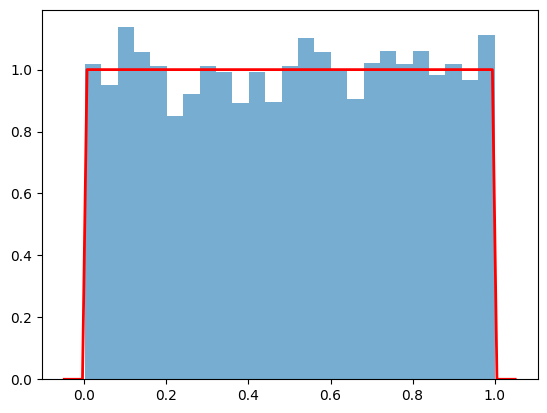

In [262]:
from scipy.stats import uniform
data_unif = uniform.rvs(size=5000)

#plt.plot(data_norm,'o');
plt.hist(data_unif, bins=25, density=True, alpha=0.6);
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = uniform.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
mu, std = norm.fit(data_norm)
plt.show()

In [ ]:
from scipy.stats import uniform
data_unif = uniform.rvs(size=5000)

#plt.plot(data_norm,'o');
plt.hist(data_unif, bins=25, density=True, alpha=0.6);
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = uniform.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
mu, std = norm.fit(data_norm)
plt.show()